✅ Person exists in group photo!


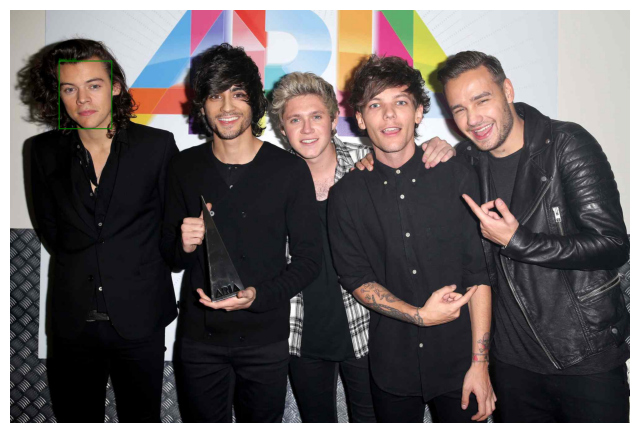

In [3]:
import torch
import numpy as np
from PIL import Image, ImageDraw
from facenet_pytorch import InceptionResnetV1, MTCNN

# ---------------------------
# Step 1: Initialize models
# ---------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(keep_all=True, device=device)   # For face detection
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)  # FaceNet embedding model

# ---------------------------
# Step 2: Helper functions
# ---------------------------
def get_embedding(img_path):
    """Detect face, align, and get embedding"""
    img = Image.open(img_path).convert("RGB")
    faces = mtcnn(img)  # detect and crop
    if faces is None:
        return None
    if faces.ndim == 3:  # single face
        faces = faces.unsqueeze(0)  # [1, 3, 160, 160]
    # Take the first detected face
    face = faces[0].unsqueeze(0).to(device)
    embedding = resnet(face)  # [1, 512]
    return embedding.detach().cpu()


def get_group_embeddings(img_path):
    """Detect all faces in group image and get embeddings + boxes"""
    img = Image.open(img_path).convert("RGB")
    boxes, _ = mtcnn.detect(img)
    faces = mtcnn(img)  # crops
    if faces is None:
        return [], [], img
    embeddings = resnet(faces.to(device)).detach().cpu()
    return embeddings, boxes, img

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# ---------------------------
# Step 3: Run face verification
# ---------------------------
query_path = "query.jpg"
group_path = "group.jpg"

query_emb = get_embedding(query_path)
if query_emb is None:
    print("❌ No face detected in query image.")
    exit()

group_embs, boxes, group_img = get_group_embeddings(group_path)
if len(group_embs) == 0:
    print("❌ No faces detected in group image.")
    exit()

# Compare embeddings
found = False
draw = ImageDraw.Draw(group_img)

for emb, box in zip(group_embs, boxes):
    sim = cosine_similarity(query_emb.numpy()[0], emb.numpy())
    if sim > 0.6:  # threshold (tuneable: 0.6–0.8 for cosine)
        found = True
        draw.rectangle(box.tolist(), outline="green", width=3)
        draw.text((box[0], box[1]-10), f"Match ({sim:.2f})", fill="green")

if found:
    print("✅ Person exists in group photo!")
else:
    print("❌ Person not found in group photo.")

# # Save result with bounding boxes
# group_img.save("output_group_result.jpg")
# print("Result saved as output_group_result.jpg")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(group_img)
plt.axis("off")
plt.show()



In [3]:
pip install torch torchvision torchaudio --upgrade


   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.4 MB 2.0 MB/s eta 0:01:58
   ---------------------------------------- 0.1/241.4 MB 1.7 MB/s eta 0:02:27
   ---------------------------------------- 0.2/241.4 MB 2.0 MB/s eta 0:02:03
   ---------------------------------------- 0.3/241.4 MB 2.0 MB/s eta 0:01:59
   ---------------------------------------- 0.5/241.4 MB 2.6 MB/s eta 0:01:34
   ---------------------------------------- 0.7/241.4 MB 2.7 MB/s eta 0:01:31
   ---------------------------------------- 1.0/241.4 MB 3.2 MB/s eta 0:01:17
   ---------------------------------------- 1.2/241.4 MB 3.2 MB/s eta 0:01:15
   ---------------------------------------- 1.4/241.4 MB 3.4 MB/s eta 0:01:11
   ---------------------------------------- 1.5/241.4 MB 3.6 MB/s eta 0:01:07
   ---------------------------------------- 1.5/241.4 MB 3.6 MB/s eta 0:01:07
   ---------------------------------------- 1.7/241.4 MB 3.2 MB/s eta 0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires torch<2.3.0,>=2.2.0, but you have torch 2.8.0 which is incompatible.
facenet-pytorch 2.6.0 requires torchvision<0.18.0,>=0.17.0, but you have torchvision 0.23.0 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
